# Face detection and recognition inference pipeline

The following example illustrates how to use the `facenet_pytorch` python package to perform face detection and recogition on an image dataset using an Inception Resnet V1 pretrained on the VGGFace2 dataset.

The following Pytorch methods are included:
* Datasets
* Dataloaders
* GPU/CPU processing

In [2]:
from facenet_pytorch import MTCNN, InceptionResnetV1
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
import numpy as np
import pandas as pd
import os

workers = 0 if os.name == 'nt' else 4

#### Determine if an nvidia GPU is available

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cpu


#### Define MTCNN module

Default params shown for illustration, but not needed. Note that, since MTCNN is a collection of neural nets and other code, the device must be passed in the following way to enable copying of objects when needed internally.

See `help(MTCNN)` for more details.

In [4]:
mtcnn = MTCNN(
    image_size=160, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, prewhiten=True,
    device=device
)

#### Define Inception Resnet V1 module

Set classify=True for pretrained classifier. For this example, we will use the model to output embeddings/CNN features. Note that for inference, it is important to set the model to `eval` mode.

See `help(InceptionResnetV1)` for more details.

In [5]:
resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)

#### Define a dataset and data loader

We add the `idx_to_class` attribute to the dataset to enable easy recoding of label indices to identity names later one.

In [6]:
def collate_fn(x):
    return x[0]

dataset = datasets.ImageFolder('../data/test_images')
dataset.idx_to_class = {i:c for c, i in dataset.class_to_idx.items()}
loader = DataLoader(dataset, collate_fn=collate_fn, num_workers=workers)

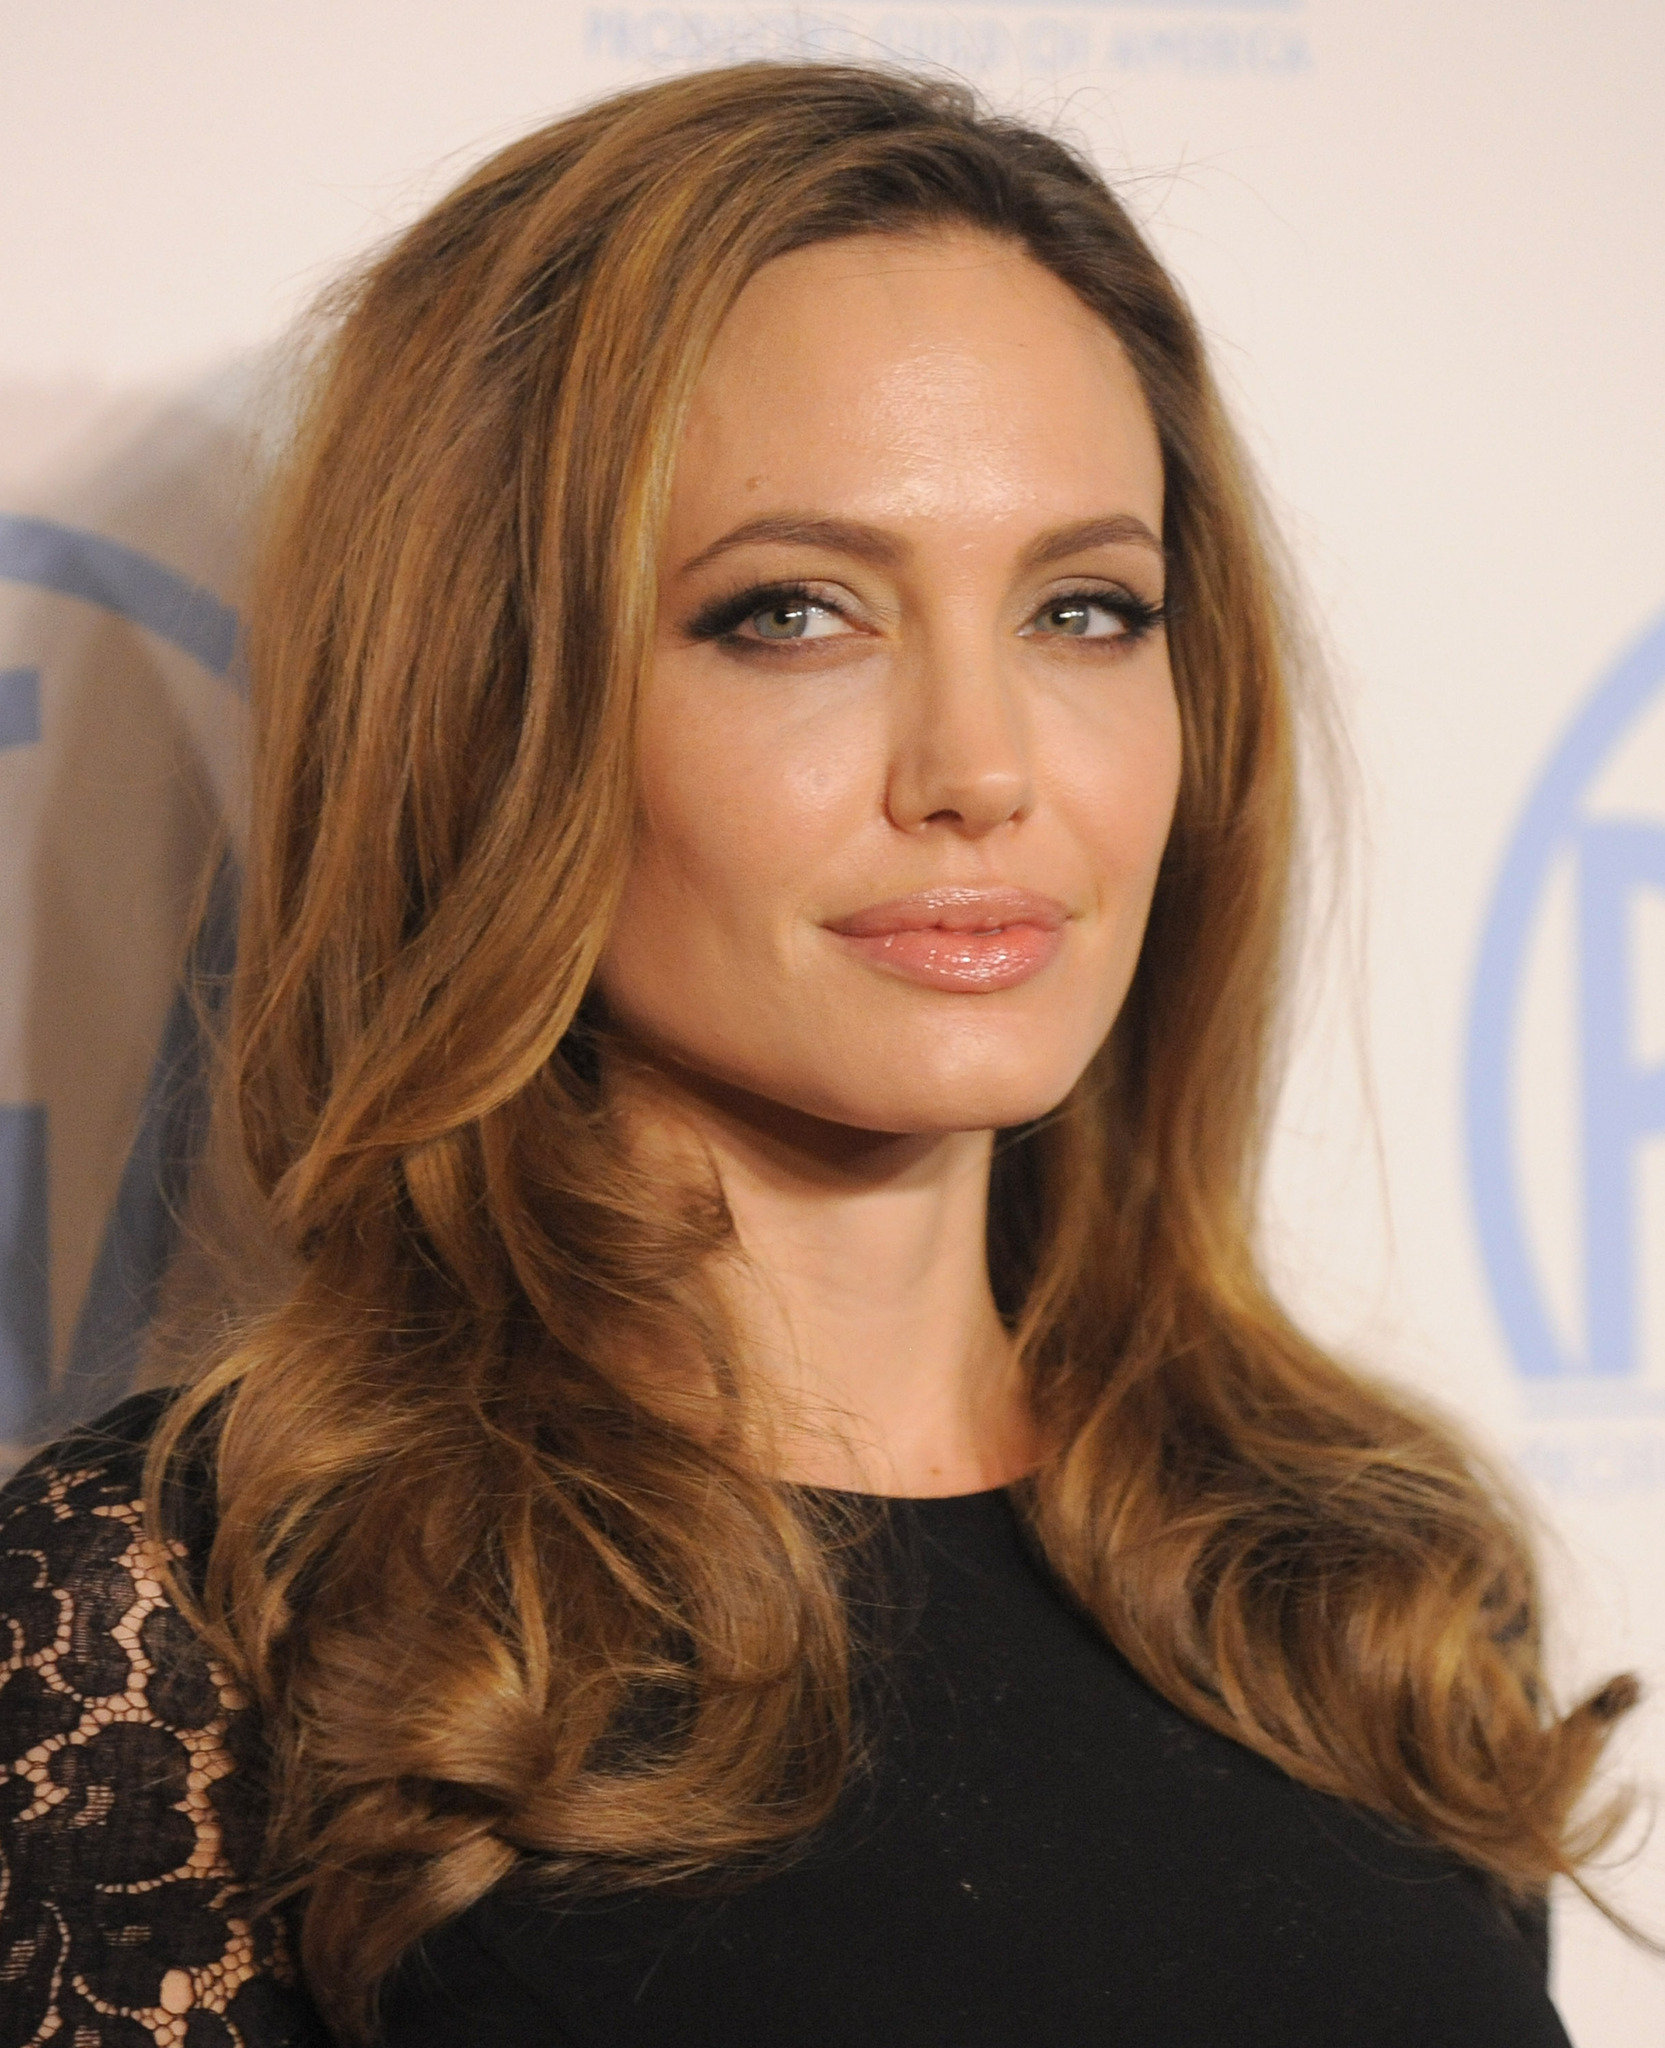

In [13]:
dataset[0][0]

#### Perfom MTCNN facial detection

Iterate through the DataLoader object and detect faces and associated detection probabilities for each. The `MTCNN` forward method returns images cropped to the detected face, if a face was detected. By default only a single detected face is returned - to have `MTCNN` return all detected faces, set `keep_all=True` when creating the MTCNN object above.

To obtain bounding boxes rather than cropped face images, you can instead call the lower-level `mtcnn.detect()` function. See `help(mtcnn.detect)` for details.

In [7]:
aligned = []
names = []
for x, y in loader:
    x_aligned, prob = mtcnn(x, return_prob=True)
    if x_aligned is not None:
        print('Face detected with probability: {:8f}'.format(prob))
        aligned.append(x_aligned)
        names.append(dataset.idx_to_class[y])

Face detected with probability: 0.999982
Face detected with probability: 0.999933
Face detected with probability: 0.999719
Face detected with probability: 0.999887
Face detected with probability: 0.999992


#### Calculate image embeddings

MTCNN will return images of faces all the same size, enabling easy batch processing with the Resnet recognition module. Here, since we only have a few images, we build a single batch and perform inference on it. 

For real datasets, code should be modified to control batch sizes being passed to the Resnet, particularly if being processed on a GPU. For repeated testing, it is best to separate face detection (using MTCNN) from embedding or classification (using InceptionResnetV1), as calculation of cropped faces or bounding boxes can then be performed a single time and detected faces saved for future use.

In [8]:
aligned = torch.stack(aligned).to(device)
embeddings = resnet(aligned).detach().cpu()

In [19]:
len(embeddings)

5

In [20]:
len(embeddings[0])

512

#### Print distance matrix for classes

In [9]:
dists = [[(e1 - e2).norm().item() for e2 in embeddings] for e1 in embeddings]
print(pd.DataFrame(dists, columns=names, index=names))

                angelina_jolie  bradley_cooper  kate_siegel  paul_rudd  \
angelina_jolie        0.000000        1.350688     0.784116   1.400938   
bradley_cooper        1.350688        0.000000     1.277162   0.902727   
kate_siegel           0.784116        1.277162     0.000000   1.344498   
paul_rudd             1.400938        0.902727     1.344498   0.000000   
shea_whigham          1.463480        0.917051     1.421880   1.000906   

                shea_whigham  
angelina_jolie      1.463480  
bradley_cooper      0.917051  
kate_siegel         1.421880  
paul_rudd           1.000906  
shea_whigham        0.000000  
